## Langevin Dynamics ##
In this notebook you will use a Verlet scheme to simulate the dynamics of a 1D- Harmonic Oscillator and 1-D double well potential using Langevin Dynamics

In [1]:
#setup the notebook
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Part 1, set up the potential and plot it  ##
This follows from the Molecular Dynamics Homework

This function has to return the energy and force for a 1d harmonic potential. The potential is
U(x) = 0.5 k (x - x0)^2 and F = -dU(x)/dx|

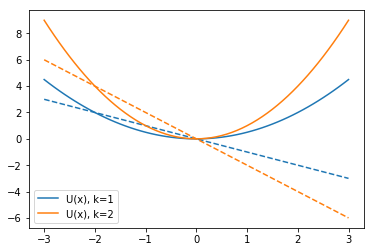

In [2]:
#this function returns the energy and force on a particle from a harmonic potential
def harmonic_oscillator_energy_force(x,k=1,x0=0):
    #calculate the energy on force on the right hand side of the equal signs
    energy = 0.5*k*(x-x0)**2
    force = -k*(x-x0)
    return energy, force

#this function will plot the energy and force
#it is very general since it uses a special python trick of taking arbitrary named arguments (**kwargs) 
#and passes them on to a specified input function
def plot_energy_force(function, xmin=-3,xmax=3,spacing=0.1,**kwargs):
    x_points = np.arange(xmin,xmax+spacing,spacing)
    energies, forces = function(x_points,**kwargs)
    label = 'U(x)'
    for arg in kwargs:
        label=label+', %s=%s'%(arg,str(kwargs[arg]))
    p = plt.plot(x_points,energies,label=label)
    plt.plot(x_points,forces,label='',color=p[0].get_color(),linestyle='--')
    plt.legend(loc=0)
    
#we can plot the energy (solid) and forces (dashed) to see if it looks right
plot_energy_force(harmonic_oscillator_energy_force,k=1)
plot_energy_force(harmonic_oscillator_energy_force,k=2)

## Part 2, code langevin dynamics ##
Now you will implement the BAOAB scheme of [Leimkuhler and Matthews (JCP, 2013)](https://aip.scitation.org/doi/abs/10.1063/1.4802990)

The following equations are repeated (Do B,A,O,A,B then repeat) to move forward in time. The A and B steps represent increments by half a time step. 

B: $v(t) \leftarrow v(t) + \frac{F(t)}{m} (dt/2)$

A: $x(t) \leftarrow x(t) + v(t) (dt/2)$


The differential equation for the O process is

$\frac{d v(t)}{dt} = - \gamma v dt + \sqrt{2 \gamma k_B T/m} d W$

($dW$ is a random differential that samples a gaussian)

Solving this tells us the update rule:

O: $v(t) \leftarrow e^{-\gamma dt} v(t) + R(t)\sqrt{k_B T/m} \sqrt{1-e^{-2\gamma dt}} $

where $R(t)$ is a gaussian random number with mean zero and standard-deviation 1.

** In the following, I'm setting the mass $m=1$ **


In [3]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new

#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new


def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=3, **kwargs ):
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = []
    velocities = []
    total_energies = []
    save_times = []
    
    while(t<max_time):
        
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        
        #A
        x = position_update(x,v,dt)

        #O
        v = random_velocity_update(v,gamma,kBT,dt)
        
        #A
        x = position_update(x,v,dt)
        
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        
        if step_number%save_frequency == 0 and step_number>0:
            e_total = .5*v*v + potential_energy

            positions.append(x)
            velocities.append(v)
            total_energies.append(e_total)
            save_times.append(t)
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

## Part 3, run  Langevin Dynamics simulation of a harmonic oscillator ##

1) Change `my_k` and see how it changes the frequency

2) Set `my_k=1`, and change my_gamma. Try lower values like 0.0001, 0.001, and higher values like 0.1, 1, 10. Do you see how underdamped, low $\gamma$, looks more like standard harmonic oscillator, while overdamped, high $\gamma$ looks more like a random walk? 


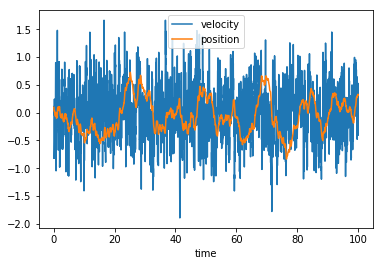

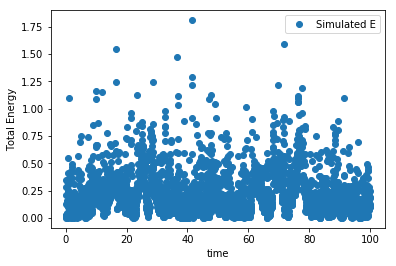

In [8]:
my_k = 2
my_max_time = 100
initial_position = .1
initial_velocity = .5

my_gamma=10
my_kBT=0.25
my_dt=0.01

times, positions, velocities, total_energies = baoab(harmonic_oscillator_energy_force, \
                                                                            my_max_time, my_dt, my_gamma, my_kBT, \
                                                                            initial_position, initial_velocity,\
                                                                            k=my_k)

plt.plot(times,velocities,marker='',label='velocity',linestyle='-')
plt.plot(times,positions,marker='',label='position',linestyle='-')

xlabel('time')
legend(loc='upper center')

plt.figure()
plt.plot(times,total_energies,marker='o',linestyle='',label='Simulated E')
xlabel('time')
ylabel("Total Energy")
legend()



### Part 4, Histogram Position and Velocity ###

What is the probability of seeing a given position or velocity? 

Now we are supposedly sampling the canonical distribution, so we should have:

$P(x) = \frac{1}{\sqrt{2 \pi k_B T /k}} e^{-\frac{k (x-x_0)^2}{2 k_B T}}$

$P(v) = \frac{1}{\sqrt{2 \pi k_B T /m}} e^{-\frac{ m v^2}{2 k_B T}}$

$P(E) = e^{-E/k_B T}/\int e^{-E/k_B T} dE = \frac{1}{k_B T} e^{-E/k_B T}$

** Set gamma to overdamped above and run the following cell **

The histograms will be compared to the exact formulas.

Text(0,0.5,'P(E)')

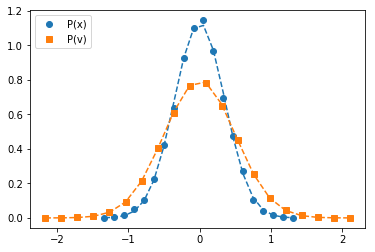

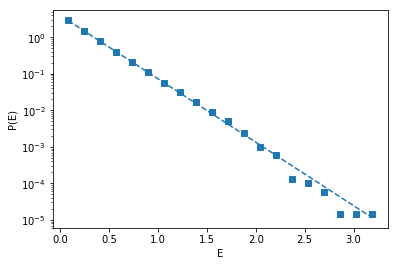

In [9]:
def bin_centers(bin_edges):
    return (bin_edges[1:]+bin_edges[:-1])/2.

def gaussian_x(x,k,kBT):
    denominator = np.sqrt(2*np.pi*kBT/k)
    numerator = np.exp(-k*(x**2)/(2*kBT))
    return numerator/denominator

def gaussian_v(v,kBT):
    denominator = np.sqrt(2*np.pi*kBT)
    numerator = np.exp(-(v**2)/(2*kBT))
    return numerator/denominator

#to get a good histogram, we need to run a lot longer than before
my_max_time = 25000

times, positions, velocities, total_energies = baoab(harmonic_oscillator_energy_force, 
                                                                            my_max_time, my_dt, my_gamma, my_kBT, \
                                                                            initial_position, initial_velocity,\
                                                                             k=my_k)

#let's only use data from the second half of the trajectory, so it can equilibrate
dist_hist, dist_bin_edges = np.histogram(positions[-len(positions)//2:],bins=20,density=True)
vel_hist, vel_bin_edges = np.histogram(velocities[-len(velocities)//2:],bins=20,density=True)
e_hist, e_bin_edges = np.histogram(total_energies[-len(total_energies)//2:],bins=20,density=True)


ideal_prediction_x = gaussian_x(x=bin_centers(dist_bin_edges),k=my_k,kBT=my_kBT )
p = plot(bin_centers(dist_bin_edges), dist_hist,marker='o',label='P(x)',linestyle='')
plot(bin_centers(dist_bin_edges), ideal_prediction_x,linestyle='--',label='', color=p[0].get_color())

ideal_prediction_v = gaussian_v(v=bin_centers(vel_bin_edges),kBT=my_kBT )
p = plot(bin_centers(vel_bin_edges), vel_hist,marker='s',label='P(v)',linestyle='')
plot(bin_centers(vel_bin_edges), ideal_prediction_v,linestyle='--',label='', color=p[0].get_color())

legend(loc='upper left')

plt.figure()
p = plot(bin_centers(e_bin_edges), e_hist,marker='s',label='P(E)',linestyle='')

#compute the energy histogram values to the boltzman factors for the observed energies
plot(bin_centers(e_bin_edges), np.exp(-bin_centers(e_bin_edges)/my_kBT)/my_kBT,linestyle='--',color=p[0].get_color())
plt.yscale('log')
plt.xlabel("E")
plt.ylabel("P(E)")

## Simulate a double well potential ##
Let's do a simulation in a double well also

$U(x) = \frac{k}{4} (x-a)^2 (x+a)^2$

This potential has a minimum at $x=a$ and $x=-a$. It also has a barrier at $x=0$. 

(-10, 10)

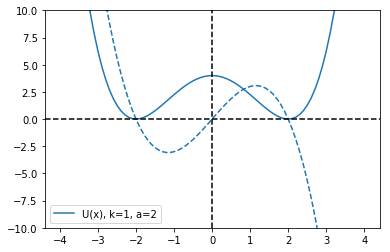

In [6]:
#this function returns the energy and force on a particle from a double well
def double_well_energy_force(x,k,a):
    #calculate the energy on force on the right hand side of the equal signs
    energy = 0.25*k*((x-a)**2) * ((x+a)**2)
    force = -k*x*(x-a)*(x+a)
    return energy, force

plot_energy_force(double_well_energy_force, xmin=-4,xmax=+4, k=1, a=2)
axhline(0,linestyle='--',color='black')
axvline(0,linestyle='--',color='black')
ylim(-10,10)

### Part 5, run langevin verlet dynamics on the double well ###
We will see what happens when we change temperature `my_KBT` and barrier height `my_a`.

1) Run the simulation as is and see that the particle samples both the left and right sides of the well

2) Lower the temperature to 0.1, what happens?

3) Keep the temperature at 1.0, and raise $a$ to 3, what happens?

*when is the sampling ergodic?*

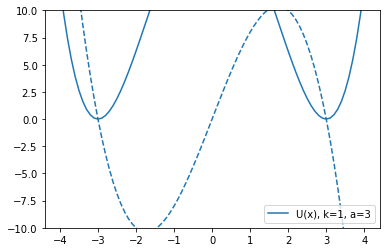

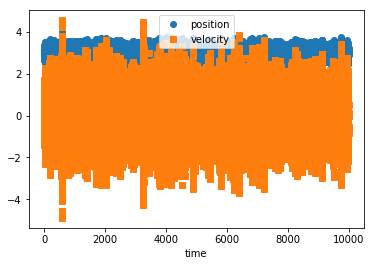

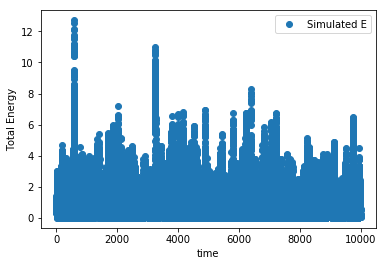

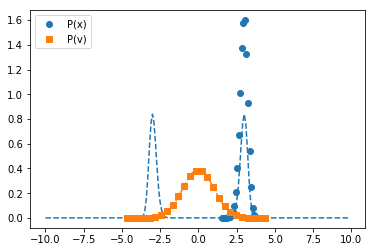

In [10]:
my_k = 1

#CHANGE THESE
my_kBT = 1.0
my_a = 3

plot_energy_force(double_well_energy_force, xmin=-4,xmax=+4, k=my_k, a=my_a)
ylim(-10,10)
plt.figure()


my_initial_position = my_a
my_initial_velocity = 1

my_gamma = 0.1
my_dt = 0.05
my_max_time = 10000



times, positions, velocities, total_energies = baoab(double_well_energy_force, 
                                                                            my_max_time, my_dt, my_gamma, my_kBT,\
                                                                            my_initial_position, my_initial_velocity,\
                                                                             k=my_k, a=my_a)

plt.plot(times,positions,marker='o',label='position',linestyle='')
plt.plot(times,velocities,marker='s',label='velocity',linestyle='')

xlabel('time')
legend(loc='upper center')

plt.figure()
initial_energy = total_energies[0]
plt.plot(times,total_energies,marker='o',linestyle='',label='Simulated E')
xlabel('time')
ylabel("Total Energy")
legend()


# histogramming the results
plt.figure()

dist_hist, dist_bin_edges = np.histogram(positions,bins=25,density=True)
vel_hist, vel_bin_edges = np.histogram(velocities,bins=25,density=True)

p = plot(bin_centers(dist_bin_edges), dist_hist,marker='o',label='P(x)',linestyle='')

#test against exact prediction
dd = 0.1
test_bin_positions = np.arange(-10,10,dd)
double_well_energies, double_well_froces = double_well_energy_force(test_bin_positions,my_k,my_a)

plot(test_bin_positions, np.exp(-double_well_energies/my_kBT)/np.sum(dd*np.exp(-double_well_energies/my_kBT)),\
     linestyle='--',color=p[0].get_color())

p = plot(bin_centers(vel_bin_edges), vel_hist,marker='s',label='P(v)',linestyle='')
ideal_prediction_v = gaussian_v(v=bin_centers(vel_bin_edges),kBT=my_kBT )
plot(bin_centers(vel_bin_edges), ideal_prediction_v,linestyle='--',label='', color=p[0].get_color())


legend(loc='upper left')